In [ ]:
%pip install --upgrade pip
%pip install pandas
%pip install numpy
%pip install datetime
%pip install collections
%pip install matplotlib.pyplot
%pip install seaborn
%pip install pyyaml
%pip install jsonlines
%pip install requests
%pip install datasets
%pip install torch
%pip install scikit-learn
%pip install tabulate

In [33]:
import sys
import os
import json
import pandas as pd
import numpy as np
import ast
import itertools
import random
import copy
from datetime import datetime
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../")

from src.helpers import io
from src.classes.dataset import Dataset
from src.classes.annotation_set import AnnotationSet

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Dataset + Annotations

In [ ]:
# FILL IN:
PATH_TO_DATASET = "data/static/wildchat4k-raw.json"
DATASET_ID = "wildchat_1m"
PATH_TO_ANNOTATIONS_DIR = "res/gpto3mini-json-wildchat"

In [62]:
# Load dataset (w/o annotations)
dataset = Dataset.load(PATH_TO_DATASET)

# Load annotations into dataset
for fpath in io.listdir_nohidden(PATH_TO_ANNOTATIONS_DIR):
    annotation_set = AnnotationSet.load_automatic(path=fpath, source="automatic_v0")
    dataset.add_annotations(annotation_set)

prompt-multi_turn_relationship: 0 / 10127 failed due to invalid annotations.
prompt-interaction_features: 0 / 10127 failed due to invalid annotations.
turn-sensitive_use_flags: 0 / 10127 failed due to invalid annotations.
turn-topic: 1 / 10127 failed due to invalid annotations.
response-interaction_features: 0 / 10127 failed due to invalid annotations.
prompt-function_purpose: 6 / 10127 failed due to invalid annotations.
prompt-media_format: 0 / 10127 failed due to invalid annotations.
response-media_format: 0 / 10127 failed due to invalid annotations.
response-answer_form: 0 / 10127 failed due to invalid annotations.


### 1. Co-occurrence Matrix for Multi-label Taxonomies
- Analysis by Zoey
- Multi-label prompt: function_purpose, interaction_features
- Multi-label response: media_format, interaction_features
- Multi-label turn: topic, sensitive_use_flags

In [ ]:
outdir = f"data/annotation_analysis_v0"
os.makedirs(outdir, exist_ok=True)

def make_cooccurrence_matrix(multilabel_pair, level_id, prompt_id, save):
    parsed_data = []
    for key, count in multilabel_pair.items():
        labels = ast.literal_eval(key)
        if len(labels) > 1:  # Skip single-label entries
            parsed_data.append((labels, count))

    all_labels = set()
    for labels, _ in parsed_data:
        all_labels.update(labels)
    all_labels = sorted(all_labels)

    co_occurrence = pd.DataFrame(0, index=all_labels, columns=all_labels)

    for labels, count in parsed_data:
        for label1, label2 in itertools.combinations_with_replacement(labels, 2):
            co_occurrence.loc[label1, label2] += count
            if label1 != label2:
                co_occurrence.loc[label2, label1] += count

    for label in all_labels:
        co_occurrence.loc[label, label] = 0

    plt.figure(figsize=(12, 10))
    sns.heatmap(co_occurrence, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Co-occurrence Matrix of {level_id} - {prompt_id}")
    plt.savefig(f"{outdir}/{save}.png", dpi=300, bbox_inches='tight')
    plt.show()

{"['Information analysis (Content explanation / interpretation)']": 824, "['Advice, Guidance, & Recommendations (Activity / product recommendations)']": 66, "['Advice, Guidance, & Recommendations (Instructions / How-to)']": 717, "['Information retrieval (general info from web)']": 1029, "['Content generation (other)']": 280, "['Translation (language to language)']": 330, "['Content generation (general prose, discussion or explanation)']": 839, "['Content generation (creative / fiction writing)']": 1798, "['Content generation (code)']": 582, "['No clear task']": 978, "['Content generation (academic / essay writing)']": 357, "['Editorial & formatting (Content expansion)']": 51, "['Editorial & formatting (Content summarization)']": 110, "['Content generation (prompts for another AI system)']": 412, "['Role-play / social simulation (romantic companion)']": 99, "['Content generation (administrative writing)']": 148, "['Editorial & formatting (Natural language content editing)']": 345, "['Re

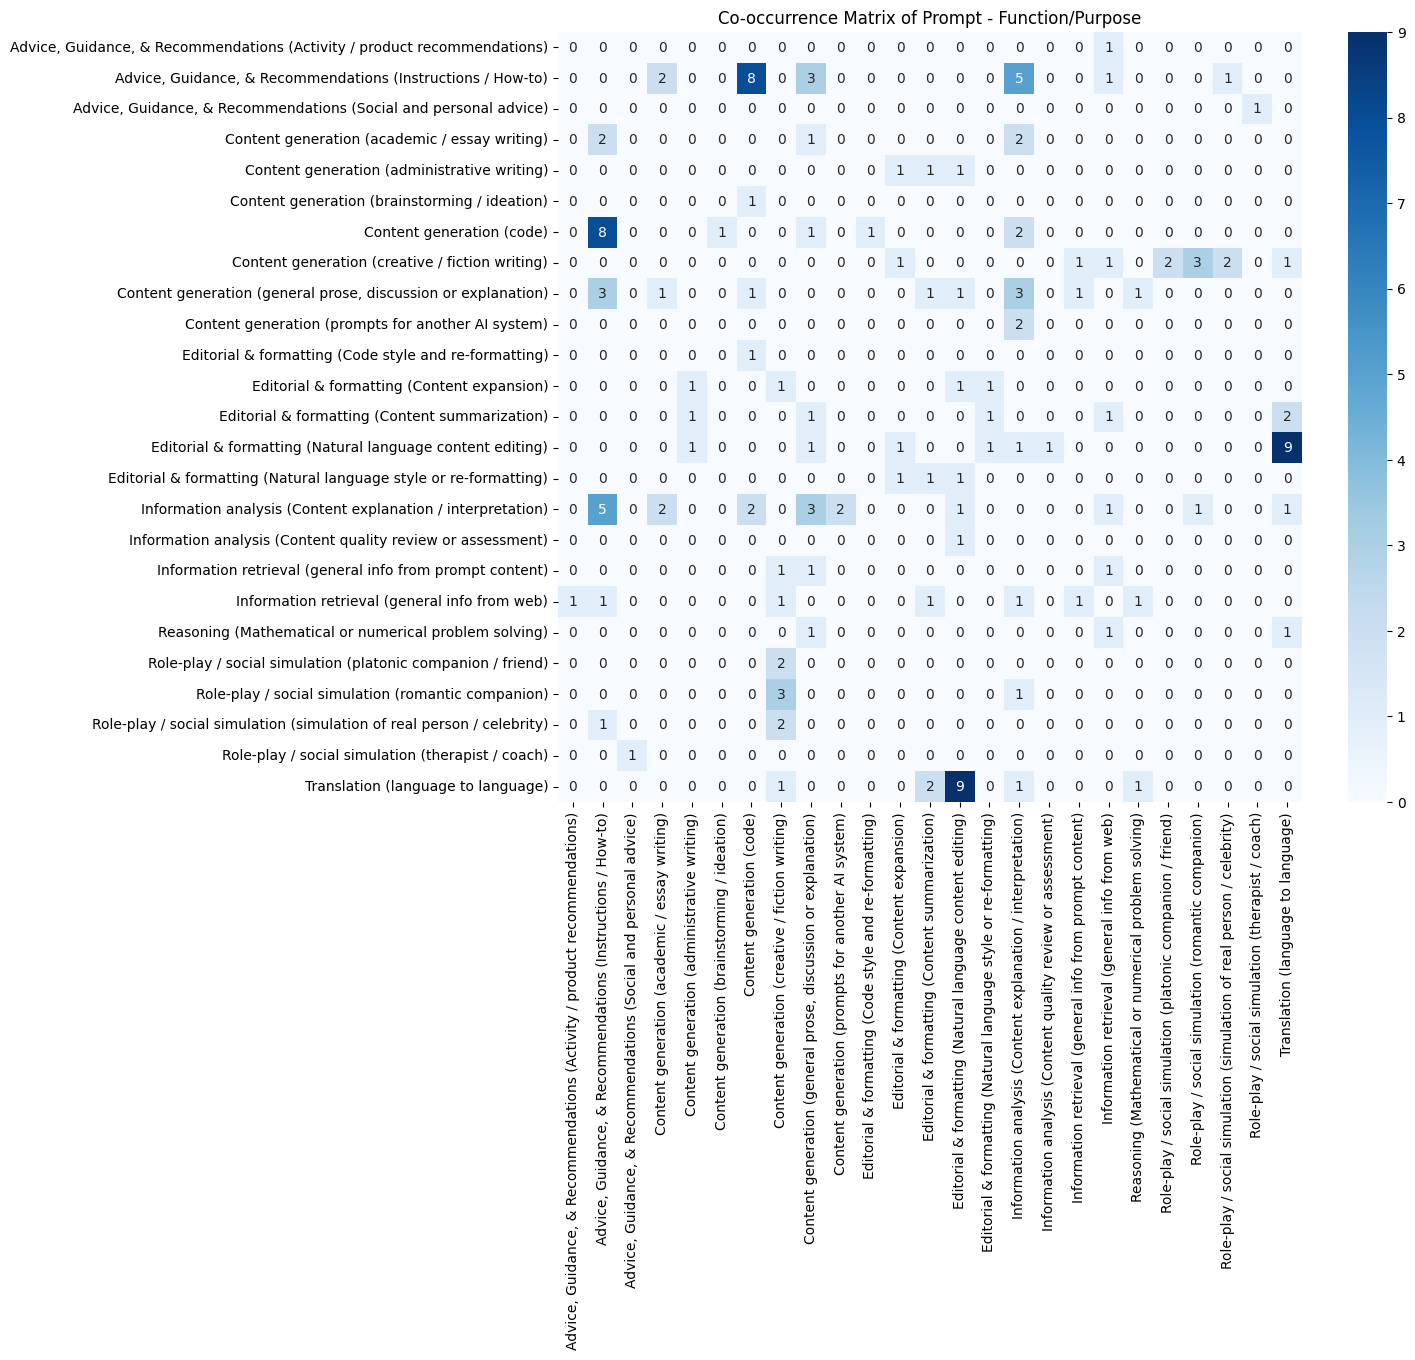

In [41]:
prompt_function_purpose_pairs = dataset.get_annotation_distribution(
    name="function_purpose",
    level="prompt",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)
print(prompt_function_purpose_pairs)
make_cooccurrence_matrix(prompt_function_purpose_pairs, "Prompt", "Function/Purpose", "coocurrence_prompt_function_purpose")

{"['None']": 8460, "['Courtesy/Politeness']": 610, "['Jailbreak attempt', 'Role-assignment']": 80, "['Role-assignment']": 614, "['Courtesy/Politeness', 'Role-assignment']": 150, "['Jailbreak attempt']": 27, "['Reinforcement/Praise/Scolding']": 119, "['Jailbreak attempt', 'Reinforcement/Praise/Scolding']": 3, "['Companionship']": 15, "['Companionship', 'Courtesy/Politeness']": 5, "['Courtesy/Politeness', 'Reinforcement/Praise/Scolding']": 11, "['Companionship', 'Courtesy/Politeness', 'Reinforcement/Praise/Scolding']": 8, "['Courtesy/Politeness', 'Jailbreak attempt', 'Role-assignment']": 8, "['Courtesy/Politeness', 'Jailbreak attempt']": 3, "['Reinforcement/Praise/Scolding', 'Role-assignment']": 4, "['Reinforcement/Praise', 'Role-assignment']": 1, "['Companionship', 'Courtesy/Politeness', 'Reinforcement/Praise/Scolding', 'Role-assignment']": 1, "['Companionship', 'Courtesy/Politeness', 'Role-assignment']": 1, "['Jailbreak attempt', 'Reinforcement/Praise/Scolding', 'Role-assignment']": 1}

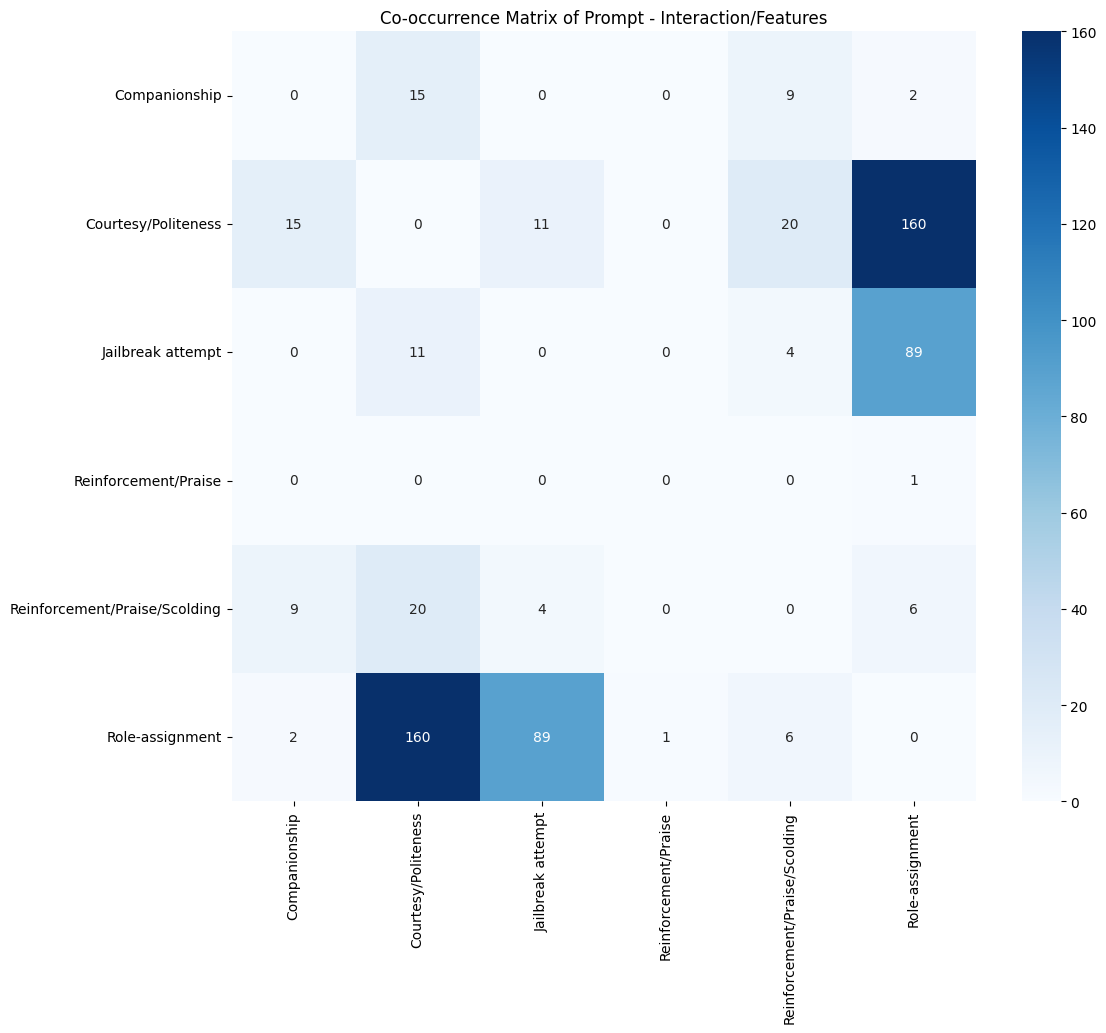

In [42]:
prompt_interaction_features_pairs = dataset.get_annotation_distribution(
    name="interaction_features",
    level="prompt",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)
print(prompt_interaction_features_pairs)
make_cooccurrence_matrix(prompt_interaction_features_pairs, "Prompt", "Interaction/Features", "coocurrence_prompt_interaction_features")

{"['Natural language']": 5817, "['Formatted enumeration/itemization (bullets/lists)', 'Natural language']": 2155, "['Formatted enumeration/itemization', 'Natural language']": 668, "['Code', 'Natural language']": 618, "['Natural language', 'URLs']": 26, "['Formatted enumeration/itemization (bullets/lists)', 'Natural language', 'URLs']": 40, "['Code', 'Formatted enumeration/itemization (bullets/lists)', 'Natural language']": 157, "['Code', 'Formatted enumeration/itemization', 'Natural language']": 133, "['Formatted enumeration/itemization (bullets/lists)', 'Math/symbols', 'Natural language']": 66, "['Math/symbols', 'Natural language']": 185, "['Charts/Graphs', 'Formatted enumeration/itemization (bullets/lists)', 'Natural language']": 2, "['Formatted enumeration/itemization', 'Natural language', 'URLs']": 15, "['Code']": 56, "['Code', 'Formatted enumeration/itemization', 'HTML', 'Natural language']": 13, "['Code', 'Images', 'Natural language']": 2, "['Code', 'Formatted enumeration/itemiza

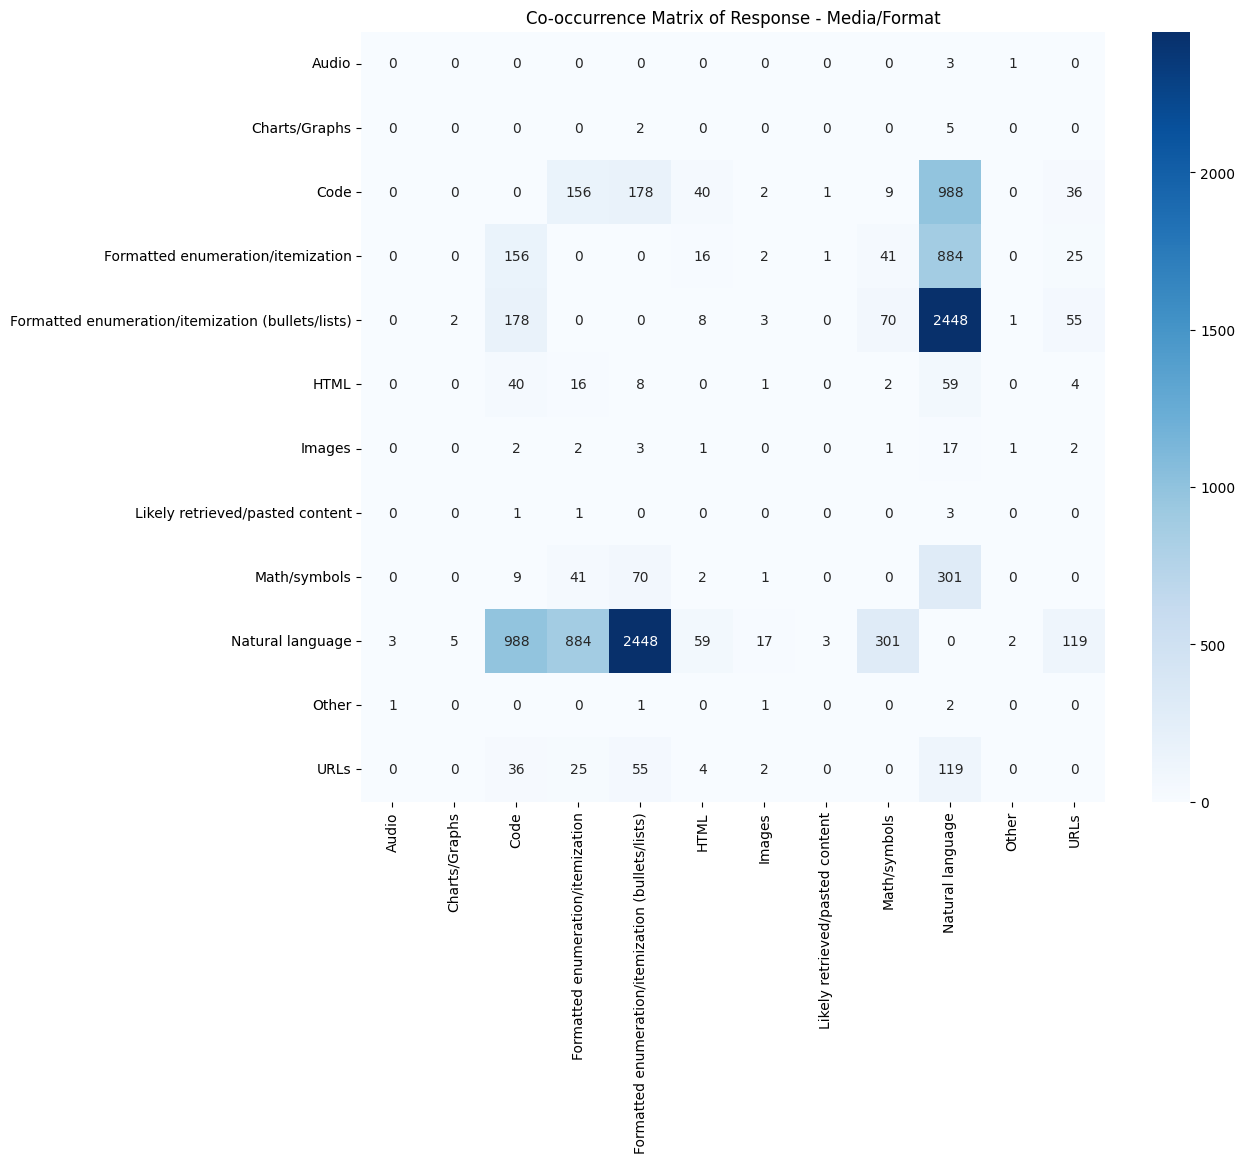

In [44]:
response_media_format_pairs = dataset.get_annotation_distribution(
    name="media_format",
    level="response",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)
print(response_media_format_pairs)
make_cooccurrence_matrix(response_media_format_pairs, "Response", "Media/Format", "coocurrence_response_media_format")

{"['Self-Disclosure']": 273, "['None']": 7320, "['Register and Style- Phatic Expressions']": 690, "['Content-Preferences/Feelings/Opinions/Religious beliefs']": 209, "['Apology', 'Self-Disclosure']": 123, "['Content-Empathy', 'Content-Preferences/Feelings/Opinions/Religious beliefs', 'Register and Style-Phatic Expressions']": 5, "['Apology', 'Register and Style- Phatic Expressions', 'Self-Disclosure']": 8, "['Content-Preferences/Feelings/Opinions']": 3, "['Apology']": 458, "['Non-Personalization', 'Self-Disclosure']": 12, "['Register and Style- Expressions of Confidence and Doubt']": 254, "['Register and Style-Expressions of Confidence and Doubt']": 19, "['Content-Preferences/Feelings/Opinions/Religious beliefs', 'Register and Style- Phatic Expressions']": 96, "['Content-Preferences/Feelings/Opinions/Religious beliefs', 'Register and Style- Expressions of Confidence and Doubt']": 26, "['Apology', 'Register and Style- Phatic Expressions']": 55, "['Register and Style- Expressions of Conf

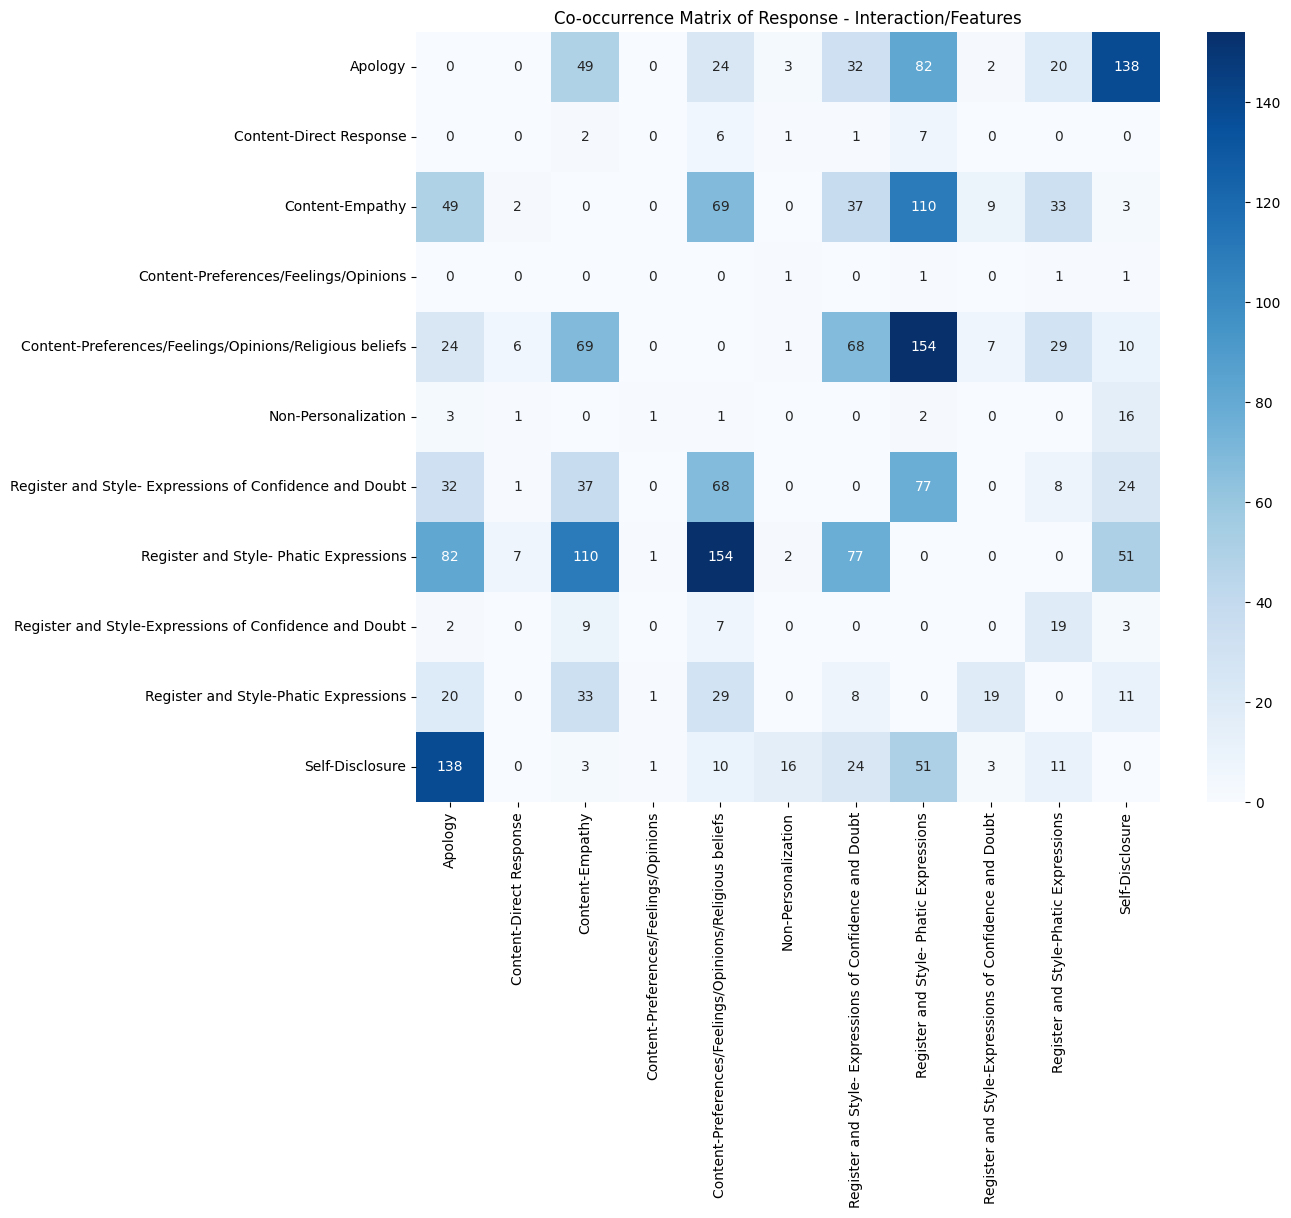

In [45]:
response_interaction_features_pairs = dataset.get_annotation_distribution(
    name="interaction_features",
    level="response",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)
print(response_interaction_features_pairs)
make_cooccurrence_matrix(response_interaction_features_pairs, "Response", "Interaction/Features", "coocurrence_response_interaction_features")

{"['Entertainment, Hobbies & Leisure']": 338, "['Employment & Hiring']": 89, "['News & Current Affairs']": 26, "['Employment & Hiring', 'Technology, Software & Computing']": 4, "['Technology, Software & Computing']": 1956, "['Food & Dining']": 66, "['Culture', 'Entertainment, Hobbies & Leisure', 'History']": 1, "['Art & Design']": 407, "['Fantasy / Fiction / Fanfiction']": 610, "['Adult & Illicit Content']": 516, "['Adult & Illicit Content', 'Fantasy / Fiction / Fanfiction']": 118, "['Adult & Illicit Content', 'Art & Design', 'Fantasy / Fiction / Fanfiction']": 2, "['Fantasy / Fiction / Fanfiction', 'News & Current Affairs', 'Politics & Elections', 'Social Issues & Movements']": 1, "['None']": 555, "['Literature & Writing']": 214, "['Education', 'Interpersonal Relationships & Communication', 'Lifestyle', 'Nature & Environment', 'Technology, Software & Computing', 'Travel & Tourism']": 1, "['Education', 'Linguistics & Languages']": 27, "['Social Issues & Movements']": 30, "['History', '

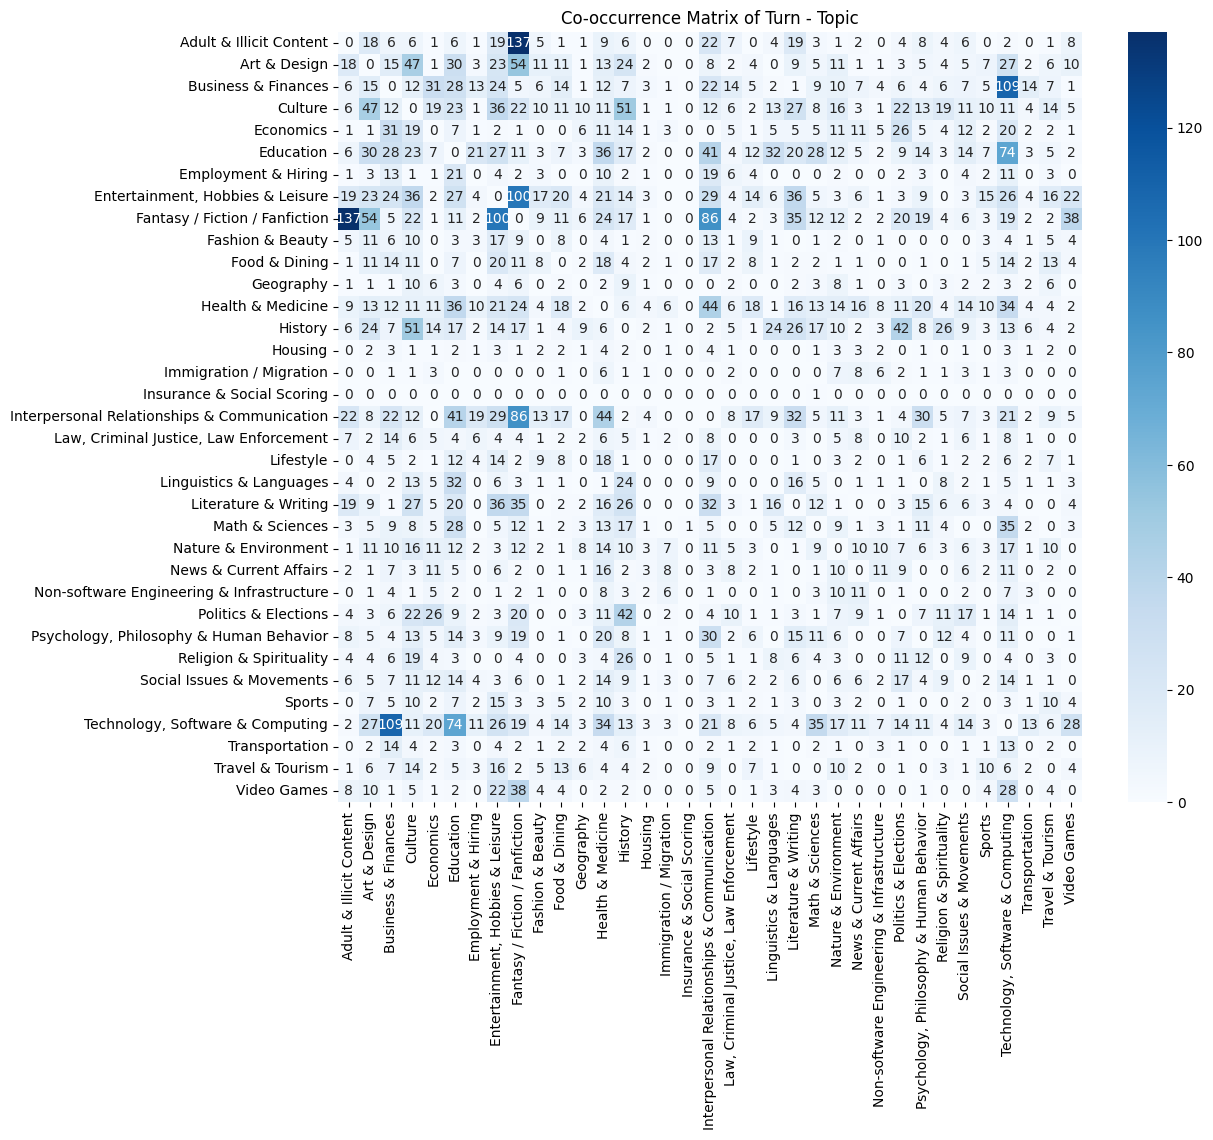

In [46]:
turn_topic_pairs = dataset.get_annotation_distribution(
    name="topic",
    level="turn",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)
print(turn_topic_pairs)
make_cooccurrence_matrix(turn_topic_pairs, "Turn", "Topic", "cooccurrence_turn_topic")

{"['None']": 9054, "['Sexually explicit content (Other)']": 491, "['Criminal planning or other suspected illegal activity not listed elsewhere']": 29, "['Inciting violence, hateful or other harmful behavior (harassment & bullying)']": 144, "['Discriminatory practices (Misrepresentation, stereotyping, or inappropriate reference to sensitive attributes)']": 34, "['Inciting violence, hateful or other harmful behavior (physical harm)']": 50, "['Sexually explicit content (fictitious person)']": 148, "['Discriminatory practices (Misrepresentation, stereotyping, or inappropriate reference to sensitive attributes)', 'Inciting violence, hateful or other harmful behavior (harassment & bullying)']": 11, "['Inciting violence, hateful or other harmful behavior (physical harm)', 'Sexually explicit content (Other)']": 10, "['Sexually explicit content (Request/discussion of CSAM)']": 25, "['Inciting violence, hateful or other harmful behavior (self-harm)']": 5, "['Inciting violence, hateful or other h

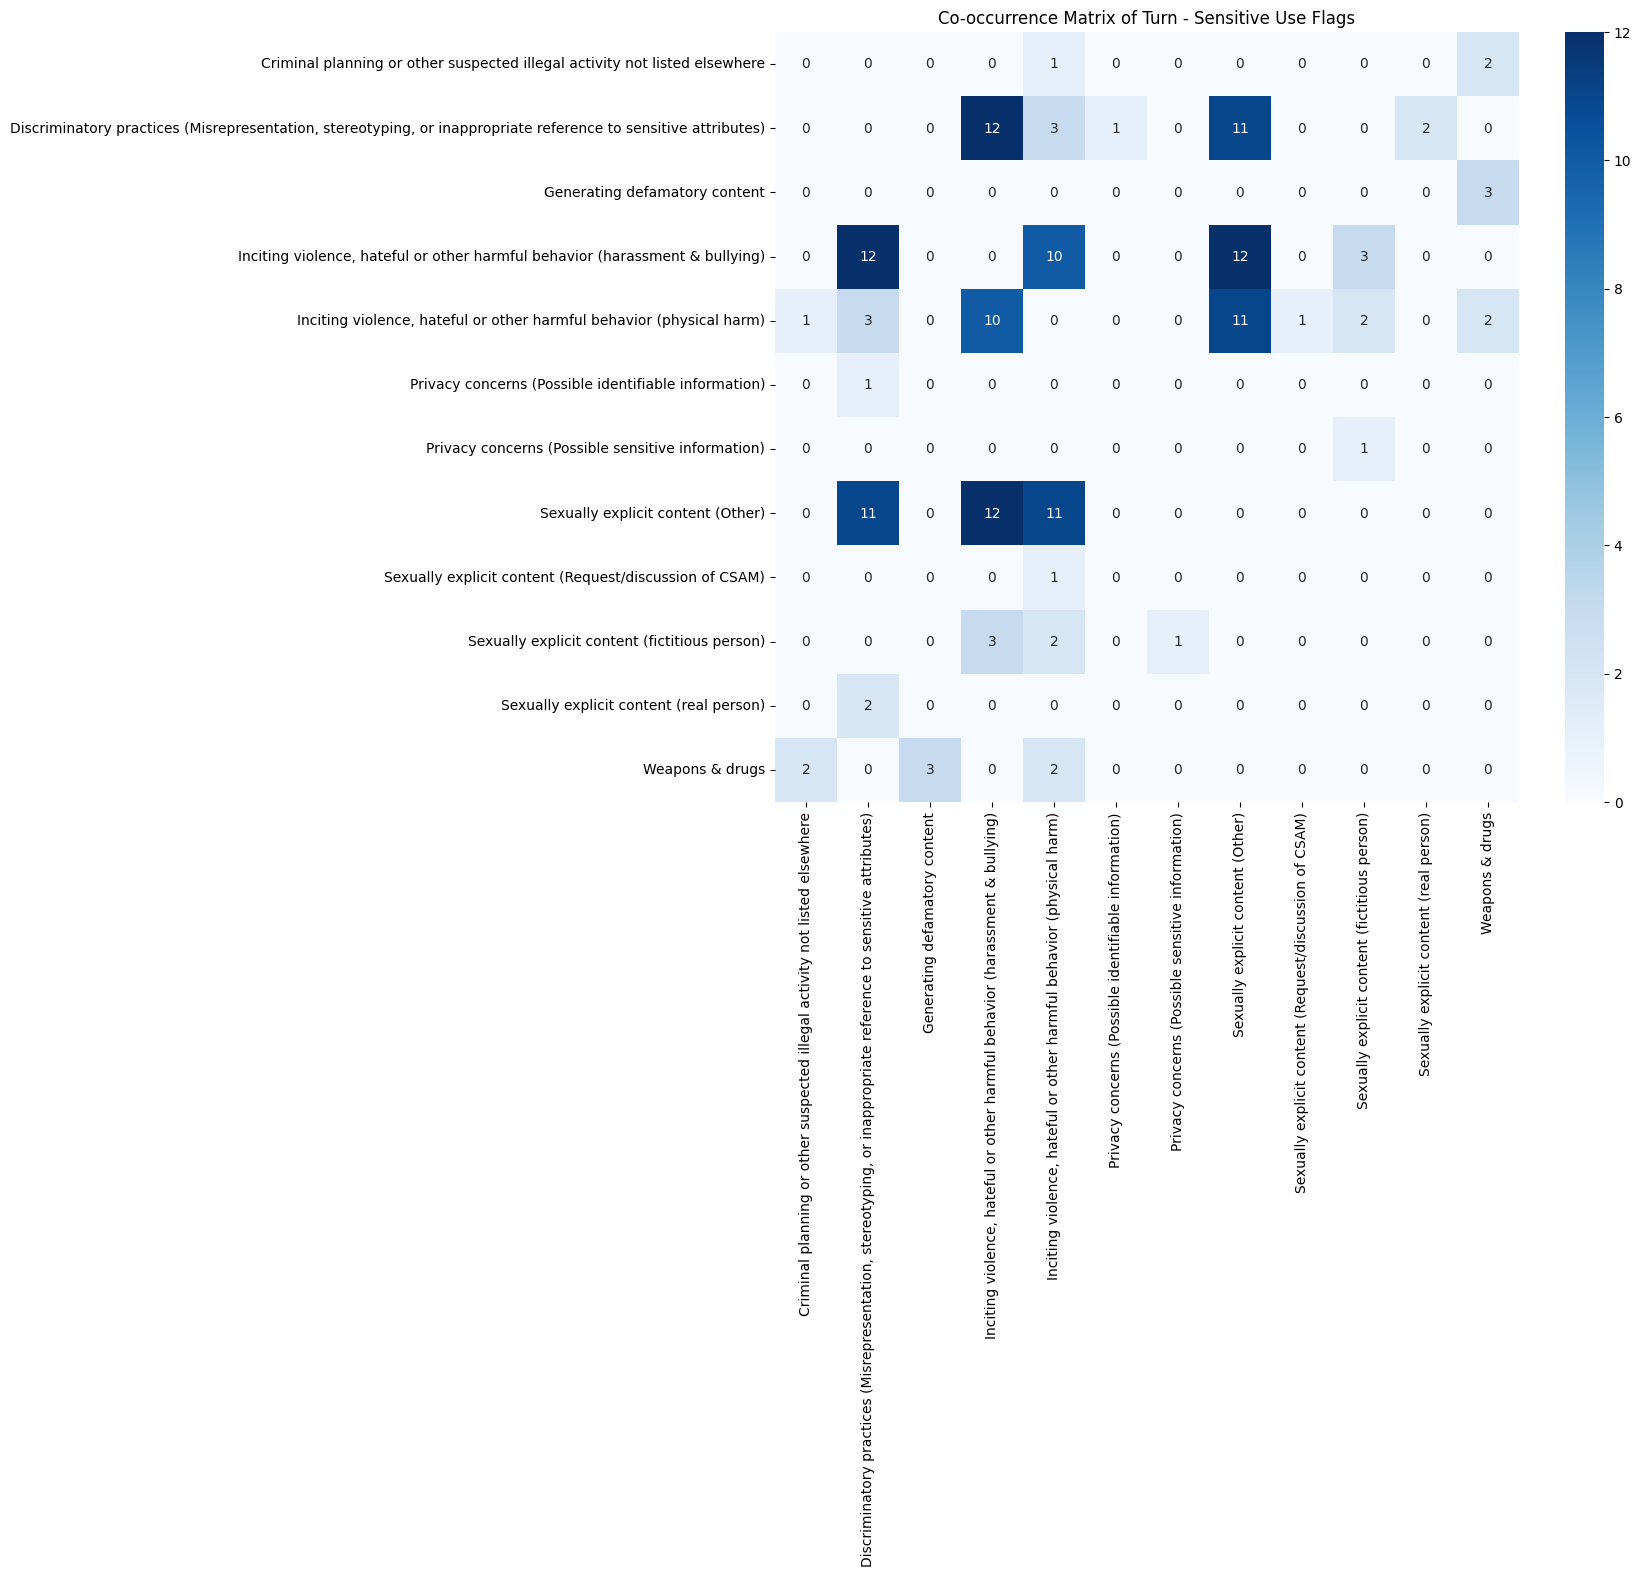

In [47]:
turn_sensitive_use_flags_pairs = dataset.get_annotation_distribution(
    name="sensitive_use_flags",
    level="turn",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)
print(turn_sensitive_use_flags_pairs)
make_cooccurrence_matrix(turn_sensitive_use_flags_pairs, "Turn", "Sensitive Use Flags", "cooccurrence_turn_sensitive_use_flags")

### 2. Multi-label Taxonomies Distribution
- Analysis by Zoey
- Q: What is the distribution of number of labels for multi-label taxonomies?

In [ ]:
def multilabel_distribution(multilabel_pair):
    label_counts = []
    for key, count in multilabel_pair.items():
        labels = ast.literal_eval(key)
        if len(labels) > 1:
            label_counts.extend([len(labels)] * count)

    count_distribution = Counter(label_counts)
    sorted_counts = dict(sorted(count_distribution.items()))
    return sorted_counts

In [53]:
multilabel_distribution(prompt_function_purpose_pairs)

{2: 77}

In [54]:
multilabel_distribution(prompt_interaction_features_pairs)

{2: 257, 3: 18, 4: 1}

In [55]:
multilabel_distribution(response_media_format_pairs)

{2: 3685, 3: 500, 4: 47, 5: 2}

In [56]:
multilabel_distribution(response_interaction_features_pairs)

{2: 607, 3: 121, 4: 22, 5: 1}

In [57]:
multilabel_distribution(turn_topic_pairs)

{2: 1535, 3: 316, 4: 106, 5: 36, 6: 21, 7: 6, 8: 4, 9: 3, 10: 3}

In [58]:
multilabel_distribution(turn_sensitive_use_flags_pairs)

{2: 68, 3: 3}

### 3. Distribution of Confidence Labels
- Analysis by Zoey
- Q: What is the distribution of confidence labels per taxonomy?

In [84]:
def plot_confidence_distribution(confidence_dist, level_id, prompt_id, save=None):
    sns.set(style="whitegrid", context="talk", palette="deep")

    bins = list(confidence_dist.keys())
    values = list(confidence_dist.values())

    total = sum(values)
    percentages = [(v / total) * 100 for v in values]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(bins, percentages, width=0.5, color="#4A90E2", edgecolor='black', linewidth=0.7)

    plt.xlabel('Confidence Score (Binned)', fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.title(f"Confidence Label Distribution {level_id} - {prompt_id}", fontsize=14, pad=10)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    for bar, perc in zip(bars, percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{perc:.1f}%', ha='center', va='bottom', fontsize=10)

    plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
    plt.tight_layout()

    if save:
        plt.savefig(f"{outdir}/{save}.png", dpi=300, bbox_inches='tight')

    plt.show()


{'0.8': 37, '0.9': 947, '1.0': 13928}


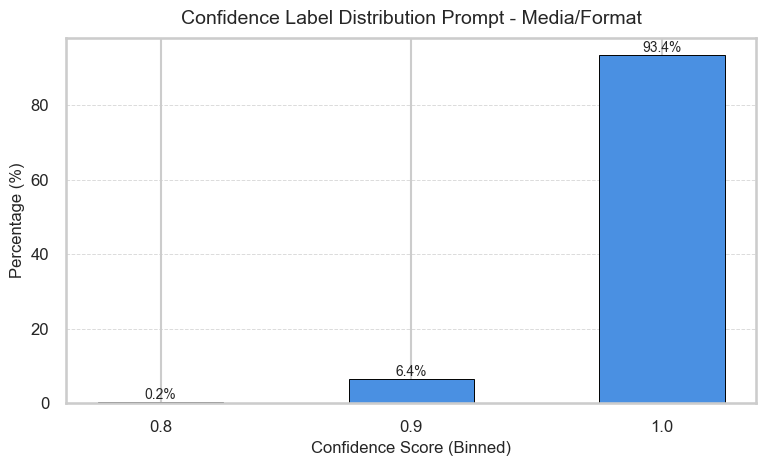

In [85]:
prompt_media_format_confidence = dataset.get_confidence_distribution(
    name="media_format",
    level="prompt",
    annotation_source="automatic_v0",
    bin_size=0.1
)
print(prompt_media_format_confidence)
plot_confidence_distribution(prompt_media_format_confidence, "Prompt", "Media/Format", "confidence_prompt_media_format")

{'0.8': 7, '0.9': 273, '1.0': 10116}


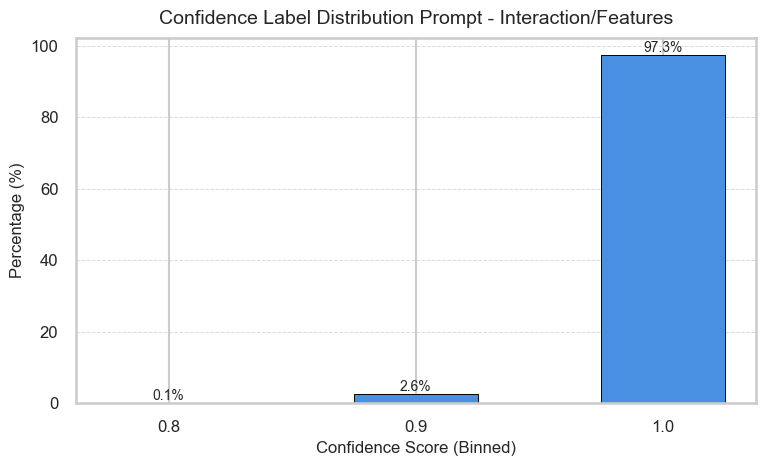

In [86]:
prompt_interaction_features_confidence = dataset.get_confidence_distribution(
    name="interaction_features",
    level="prompt",
    annotation_source="automatic_v0",
    bin_size=0.1
)
print(prompt_interaction_features_confidence)
plot_confidence_distribution(prompt_interaction_features_confidence, "Prompt", "Interaction/Features", "confidence_prompt_interaction_features")

{'0.7': 3, '0.8': 23, '0.9': 2290, '1.0': 7871}


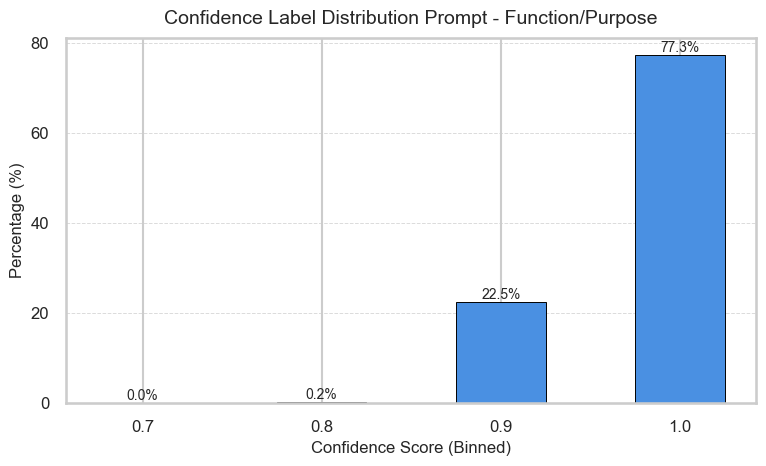

In [87]:
prompt_function_purpose_confidence = dataset.get_confidence_distribution(
    name="function_purpose",
    level="prompt",
    annotation_source="automatic_v0",
    bin_size=0.1
)
print(prompt_function_purpose_confidence)
plot_confidence_distribution(prompt_function_purpose_confidence, "Prompt", "Function/Purpose", "confidence_prompt_function_purpose")

{'0.5': 5, '0.6': 1, '0.7': 7, '0.8': 25, '0.9': 1110, '1.0': 8973}


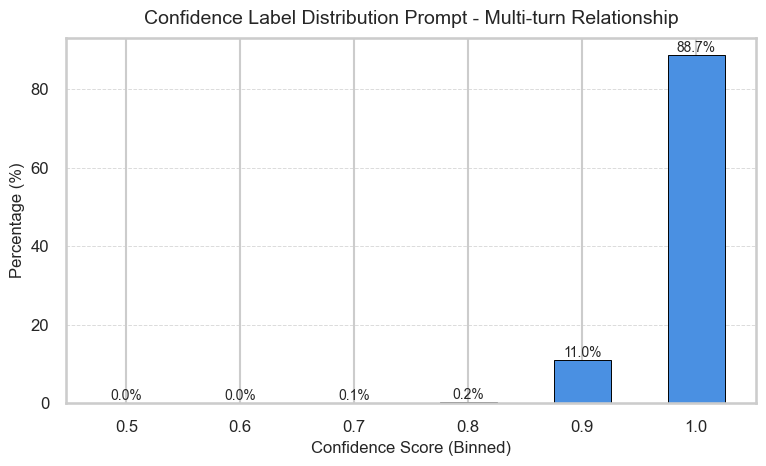

In [88]:
prompt_multi_turn_relationship_confidence = dataset.get_confidence_distribution(
    name="multi_turn_relationship",
    level="prompt",
    annotation_source="automatic_v0",
    bin_size=0.1
)
print(prompt_multi_turn_relationship_confidence)
plot_confidence_distribution(prompt_multi_turn_relationship_confidence, "Prompt", "Multi-turn Relationship", "confidence_prompt_multi_turn_relationship")

{'0.8': 13, '0.9': 425, '1.0': 14398}


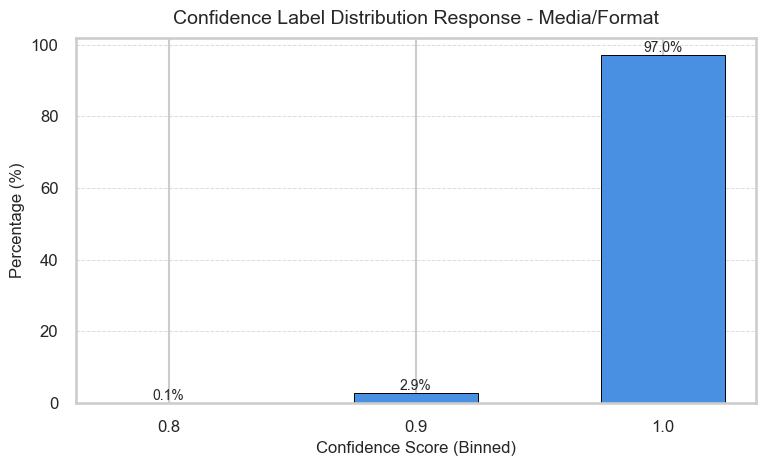

In [89]:
response_media_format_confidence = dataset.get_confidence_distribution(
    name="media_format",
    level="response",
    annotation_source="automatic_v0",
    bin_size=0.1
)
print(response_media_format_confidence)
plot_confidence_distribution(response_media_format_confidence, "Response", "Media/Format", "confidence_response_media_format")

{'0.7': 1, '0.8': 63, '0.9': 914, '1.0': 10051}


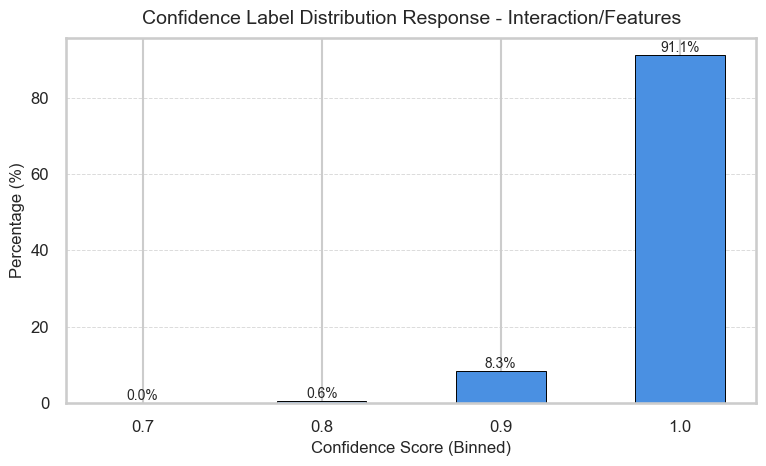

In [90]:
response_interaction_features_confidence = dataset.get_confidence_distribution(
    name="interaction_features",
    level="response",
    annotation_source="automatic_v0",
    bin_size=0.1
)
print(response_interaction_features_confidence)
plot_confidence_distribution(response_interaction_features_confidence, "Response", "Interaction/Features", "confidence_response_interaction_features")

{'0.5': 3, '0.6': 11, '0.7': 48, '0.8': 421, '0.9': 4127, '1.0': 8176}


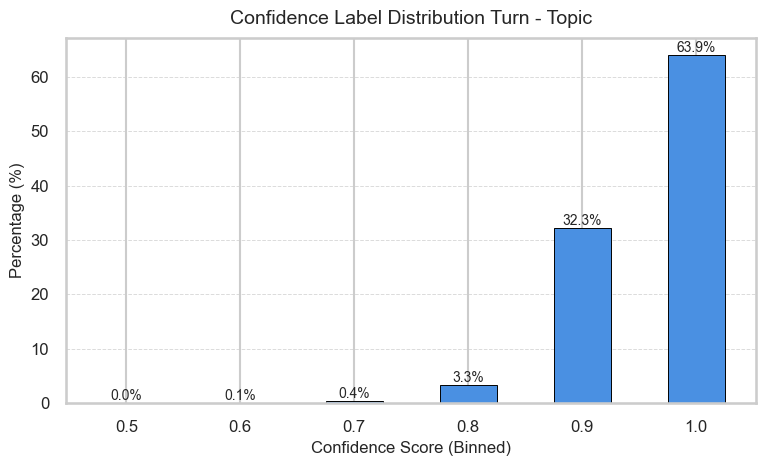

In [91]:
turn_topic_confidence = dataset.get_confidence_distribution(
    name="topic",
    level="turn",
    annotation_source="automatic_v0",
    bin_size=0.1
)
print(turn_topic_confidence)
plot_confidence_distribution(turn_topic_confidence, "Turn", "Topic", "confidence_turn_topic")

{'0.8': 9, '0.9': 334, '1.0': 9850}


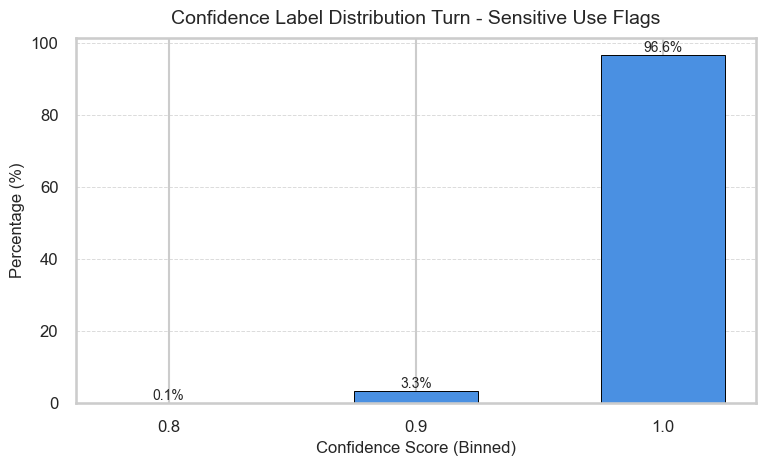

In [92]:
turn_sensitive_use_flags_confidence = dataset.get_confidence_distribution(
    name="sensitive_use_flags",
    level="turn",
    annotation_source="automatic_v0",
    bin_size=0.1
)
print(turn_sensitive_use_flags_confidence)
plot_confidence_distribution(turn_sensitive_use_flags_confidence, "Turn", "Sensitive Use Flags", "confidence_turn_sensitive_use_flags")